# Diffusion maps 3

#### Author: Yu-Jie Ho, 2019

### Abstract

Diffusion map [1] is a dimensionality reduction method in order to find meaningful structure which points are embedded in. After [first sight of constructing diffusion maps](), and [an understanding of self-tuning scaling](), I will consolidate what I have learned and make a complete description for diffusion map in the following article, including the definition of diffusion matrix, diffusion distance, diffusion process and diffusion map. Then I will display the algorithm and my Python code.

### Introduction

For many modern data sets (e.g., financial and consumer data, DNA microarrays, text documents), the collected data are often high-dimensional, noisy and unordered, which makes it hard to find meaningful structures. Diffusion map is a mathematical technique for analysing and organising such data, which is done by reducing the dimension of points, that is, finding a lower-dimensional manifold which points are embedded in. The new representation of points in such structure should preserve the important relationships, such as local mutual distance, between them.

Unlike other method for dimensionality reduction (such as Principal Component Analysis, PCA), diffusion map is still useful when data in data space have nonlinear shapes, since it focus on discovering the underlying manifold. In comparisons, the technique is also robust to noise perturbation and computationally inexpensive.

### Framework

Given a data set $X=\{x_1,...,x_n\} \in \mathbb{R}^p$, I will discribe this technique and construct it by using following steps:

1. ##### Define a kernel and create the kernel matrix

>Consider Guassian kernel $$ k(x_{i},x_{j}) = \exp(-\frac{\lVert x_{i}-x_{j} \rVert^2}{\sigma_i \sigma_j}) $$
where $ \sigma_i=\lVert x_i-x_s \rVert^2 $ and $x_s$ is the $s$'th neighber of point $x_i$. Define the kernel matrix $K$, with entries $ K_{ij}=k(x_{i},x_{j}) $. 

$\sigma_i$ is the local scaling parameter, which I have studied in the [privious project]().

Note that $K$ is a $n*n$ symmetric matrix, the value of the entries is between 0 and 1, and is equal to 0 on the diagonal. Also, it is small if two data points, $x_i$ and $x_j$, are far away from each other in the data space; and is large if opposite.

Next, we bring up the connectivity between two data points $x_i$ and $x_j$, which is consider as the probability of jumping from $x_i$ to $x_j$ in one step of random walk. The relation between probability function and kernel function is
$$ p(x,y)=\frac{k(x,y)}{\sum_{y\in X} k(x,y)} $$

Define the diffusion matrix $P$, with entries $ P_{ij}=p(x_{i},x_{j}) $. Note that $P$ is not symmetric and has a discrete sequence of eigenvalues $1=\lambda_0 > \lvert \lambda_1 \rvert \geq \lvert \lambda_2 \rvert \geq \cdots$.

Let $D$ be a $n*n$ diagonal matrix with $$ D_{ii}=(\sum_{j=1}^n K_{ij})^{1/2}, $$
then $ P=D^{-2}K $. Consider another matrix $Q$, define as $ Q=DP D^{-1} $, we have that
* $Q$ is symmetric.
* $Q$ has same eigenvalues as $P$.
* eigenvectors of $Q$, denoted as $e_k$, are multiplied by $D^{-1}$ and $D$ to get the right and left eigenvectors of $P$ respectively.

2. ##### Row normalize the kernel matrix

Althouth $P$ is what we need, it is more convenient for us to compute the matrix $Q$.
>$$ Q=DP D^{-1}=D(D^{-2}K) D^{-1}=D^{-1}K D^{-1}. $$

By taking powers of $P$, we increase the number of steps taken, that is, $P_{ij}^{t}$ sum all paths that take $t$ steps from $x_i$ to $x_j$, this is called the diffusion process.

When increasing value $t$, the probability of following a path along the underlying geometric structure of the data set increases, since along the geometric structure, points are dense and therefore highly connected, pathways form along short and high probability jumps.

Now, we define the diffusion distance
$$ D_t(x_i,x_j)^2 = \sum_{u\in X}\lvert p_t(x_i,u)-p_t(u,x_j)\rvert^2 =
\sum_{k=1}^{n}\lvert P_{ik}^t-P_{kj}^t \rvert^2 $$
It is small if there are many high probability paths of taking $t$ steps from one point to another.

3. ##### Find eigenvectors and eigenvalues of the diffusion matrix

As we mention earlier,
>the eigenvalues of $P$ is equal to the eigenvalues of $Q$, and the right and left eigenvectors of $P$ are
$$ \psi_k=D^{-1} e_k , \phi_k=D e_k $$ respectively.

4. ##### Get the diffusion map and treat each row as a point coordinate

>We define a diffusion map $Y$, which maps corrdinates between data and diffusion space, with its column $$ Y_i=
\left[
\begin{matrix}
 p_t(x_i,x_1)  \\
 p_t(x_i,x_2)  \\
 \vdots        \\
 p_t(x_i,x_n)  \\
\end{matrix}
\right]
=
\left[
\begin{matrix}
 \lambda_i^t \psi_i  \\
\end{matrix}
\right]
= P_{i}^t $$

For this map, $$ \lVert Y_i-Y_j \rVert_E^2 = \sum_{u\in X}\lvert p_t(x_i,u)-p_t(x_j,u)\rvert^2 = 
\sum_{k=1}^{n}\lvert P_{ik}^t-P_{kj}^t \rvert^2 = D_t(x_i,x_j)^2 $$
the diffusion distance in data space simply become the Euclidean distance in the diffusion space.

Dimensional reduction is done by neglecting certain dimensions in the diffusion space, since the orthogonal left eigenvectors of $P$ form a basis for the diffusion space, the eigenvalues indicate the importance of each dimension, and is arrange in descending power as we mention earlier.

## Implementation

Python code that implement diffusion maps using the steps above.

### 1. Import some libraries for programming

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### 2. Define functions

The functioning of get_K is to get the Guassian kernel matrix.

In [2]:
def get_K(Dis, sigma):
    list1=[]

    for i in range(n):
        for j in range(n):
            list1.append( exp(-Dis[i][j]*Dis[i][j]/(sigma[i]*sigma[j])) )
    K = array(list1).reshape(n, n)
    
    return K    #Guassian kernel matrix

The functioning of get_D is to get the diagonal matrix $D$ we mention above.

In [3]:
def get_D(K):
    list1=[]
    
    for i in range(n): list1.append( sqrt(sum(K[i])) )
    D = diag(list1)
    
    return D

The functioning of get_Q is to get matrix $Q$ we mention above.

In [4]:
def get_Q(K, D):
    
    Q = dot( dot(inv(D), K), inv(D) )
    
    return Q    #Q is the matrix we define earlier, i.e., Q=D^(-1)KD^(-1)

The functioning of get_eig is to get the eigenvalues and eigenvectors of diffusion matrix $P$.  

In [5]:
from scipy.sparse.linalg import svds

def get_eig(Q, D, c):
    [U, S, V] = svds(Q, c)    #compute the largest c singular values/vectors for a sparse matrix
                                #since Q is a real symmetric matrix, singular values and non-negative
                                #eigenvalues coincide
    eigenvals = flip(S).reshape(c,1)
    
    for i in range(n): U[i]=flip(U[i])
    psi = dot(inv(D), U)
    
    return [psi, eigenvals]    #non-trivial eigenvalues and right eigenvectors of diff matrix

The functioning of get_Y is to get the diffusion map $Y$.

In [6]:
def get_Y(psi, eigenvals, c):
    list1=[]
    
    for i in range(n):
        for j in range(c): list1.append( psi[i][j]*eigenvals[j] )
    Y = array(list1).reshape(n, c)
        
    return Y    #diffusion map

The functioning of get_labels is to get the labels of data via k-means.

In [7]:
from sklearn.cluster import KMeans

def get_labels(Y, clusters):

    kmeans = KMeans(clusters)
    kmeans = kmeans.fit(Y)
    labels = array(kmeans.predict(Y)).reshape(n,1)
    
    return labels

### 3. Load data

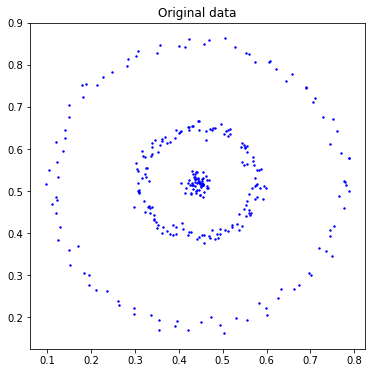

In [8]:
from scipy.io import loadmat

ori = loadmat('Data/Data2.mat')

n = len(ori['data'])       #number of points
p = len(ori['data'][0])    #dimension of points

for i in range(n):
    plt.scatter(ori['data'][i][0],ori['data'][i][1], s=2, c="blue")
plt.title("Original data")
plt.gcf().set_size_inches(6,6)
plt.show()

### 4. Set parameters for diffusion map

D : matrix of Euclidean distance of data points in $\mathbb{R}^p$.  
c : the largest $c$ eigenvalues, that is, the largest dimension we consider.  
s : parameter $s$ for constructing costumize sigma.  
sigma : a list of local scaling parameters $\sigma_i$, which is required in the Guassian kernel function.  
clusters : numbers of groups.

In [9]:
from scipy.spatial.distance import squareform, pdist
Dis = squareform(pdist(ori['data']))
c = 3

s = 7
sigma=[]
Dis_sort = sort(Dis,1)    # distance of one point to another arrange in descending power
for i in range(n): sigma.append( Dis_sort[i][s+1] )
    
clusters = 3

### 5. Calculation

In [10]:
def diffuse(Dis, sigma, c, clusters):
    
    K = get_K(Dis, sigma)
    D = get_D(K)
    Q = get_Q(K, D)
    psi, eigenvals = get_eig(Q, D, c)
    Y = get_Y(psi, eigenvals, c)
    labels = get_labels(Y, clusters)
    
    return Y, labels

In [11]:
Y, labels = diffuse(Dis, sigma, c, clusters)

### 6. Display the result

##### 6.1 Show the diffusion space

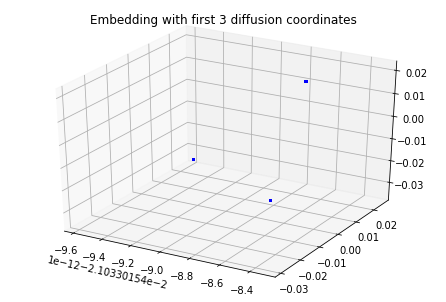

In [12]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
for i in range(n): ax.scatter(Y[i][0],Y[i][1],Y[i][2],s=2, c='b')
ax.set_title('Embedding with first 3 diffusion coordinates')
plt.show()

##### 6.2. Show the labeling

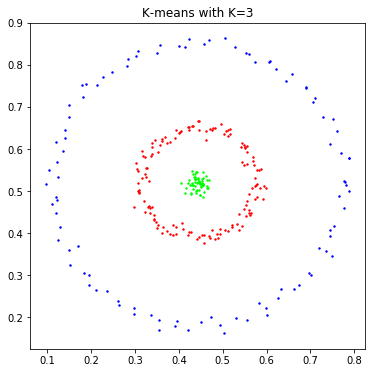

In [13]:
cmap = cm.brg
norm = Normalize(1, clusters)

for i in range(n):
    plt.scatter(ori['data'][i][0], ori['data'][i][1], s=2, c=cmap(norm(labels[i]+1)) )
plt.title('K-means with K=3')
plt.gcf().set_size_inches(6,6)
plt.show()

## Conclusion

We describe the full view of diffusion map, a method of dimensionality reduction. We show how to use a kernel function to recover the diffusion matrix and distance, and the relationship between diffusion distance and map. We show that in the lower-dimensional space, the structure of data still be preserved and we can analyze it more easily.

## References

[1] R.R. Coifman and S. Lafon, Diffusion maps, Applied and computational harmonic analysis, 21:5–30, 2006  
[2] J. de la Porte, B. M. Herbst, W. Hereman and S. J. van der Walt., An Introduction to Diffusion Maps, Proceedings of the Nineteenth Annual Symposium of the Pattern Recognition Association of South Africa, 2008  
[3] L. Zelnik-Manor and P. Perona, Self-Tuning Spectral Clustering, Advances in Neural Information Processing Systems 17:1601-1608, 2005